<a href="https://colab.research.google.com/github/evmpython/linkedin/blob/main/01_precipitacao_diaria_MERGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **ACUMULADO DE PRECIPITAÇÃO COM DADOS DO MERGE**
---

- MERGE `DIÁRIO`

1. Site: http://ftp.cptec.inpe.br/modelos/tempo/MERGE/
2. url dos dados: http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/
3. Informações: http://ftp.cptec.inpe.br/modelos/tempo/MERGE/READ_ME-MERGE.pdf


---


- Código realizado por: Enrique V. Mattos -- 02/05/2024 - enrique@unifei.edu.br


---



# **1° Passo:** Instalando as bibliotecas

In [1]:
# Instalando matplotlib, proplot e numpy
!pip install -q matplotlib==3.4.3
!pip install -q proplot==0.9.7
!pip install -q numpy==1.24.3

# Instalando salem
!pip install -q salem==0.3.9

# Instalando Xarray e suas dependências: https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
!pip install -q xarray dask netCDF4 bottleneck

# Instalando rasterio, pyproj e geopandas
!pip install -q rasterio pyproj geopandas

# Instalando a Pygrib
!pip install -q pygrib

# foi usado devido ao pygrib não funcionar com a versão padrão do colab
!pip install -U numpy

# Instalando cartopy
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 3.4.3 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.24.3 which is incompatible.
plotnine 0.12.4 requires matplotlib>=3.6.0, but you have matplotlib 3.4.3 which is incompatible.
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 3.4.3 which is incompa

- Chegando aqui, será necessário fazer a `Reinicialização do Ambiente de Execução`. Para isto, você deverá acessar `Ambiente de execução`, localizado na barra de ferramentas e clicar em `Reiniciar Sessão`. Como indicado na imagem abaixo.

- Em seguida você deverá rodar novamente a célula anterior de instalações, de forma que as bibliotecas sejam instaladas novamente.

- Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab. Então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

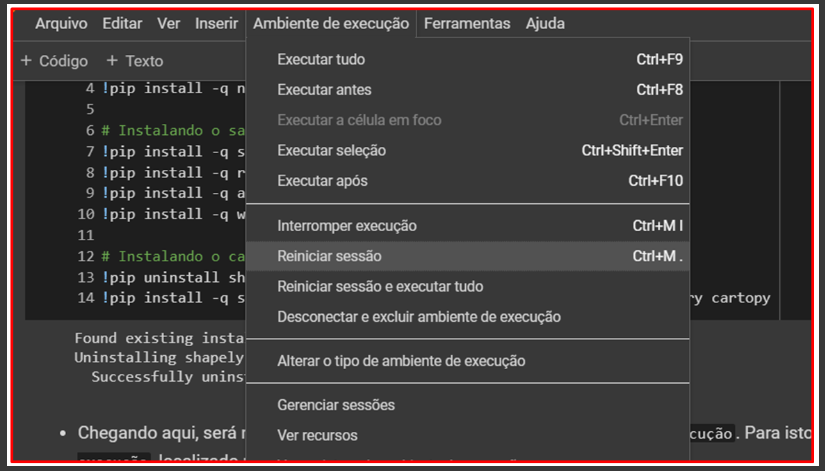

# **2° Passo:** Importando bibliotecas

In [2]:
import xarray as xr
import time
import proplot as pplt
import salem
import matplotlib
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import numpy as np
import calendar
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import pygrib
import scipy.ndimage
import os

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


# **3° Passo:** Carrega shapefile

In [3]:
# url dos shapefiles
url = 'https://github.com/evmpython/shapefile/raw/main/'

# leitura do shapefile com a biblioteca SALEM
shp = salem.read_shapefile(f'{url}brasil/BRAZIL.shp')

# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

#Define a data inicial e final

In [4]:
# define mês e ano
anoi, mesi, diai = '2024', '04', '26'
anof, mesf, diaf = '2024', '05', '01'

# selecina a extensão da imagem [min. lon, min. lat, max. lon, max. lat]
extent = [lonmin, latmin, lonmax, latmax]

#Carrega os dados do `MERGE`

Baixa os dados diários do MERGE

In [ ]:
%%time
import calendar

# ano, mês e dia INICIAL do período
anoii = int(anoi)
mesii = int(mesi)
diaii = int(diai)

# ano, mês e dia FINAL do período
anoff = int(anof)
mesff = int(mesf)
diaff = int(diaf)

# FTP dos dados por dia
ftp = 'http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/'

# Data desejada
date_in = datetime(anoii, mesii, diaii)
date_ini = date_in.strftime('%Y%m%d')

date_en = datetime(anoff, mesff, diaff)
date_end = date_en.strftime('%Y%m%d')

# Número de dias
n_days = date_en - date_in

# Download dos dados
for file in pd.date_range(date_ini, date_end, freq='d'):

    # extrai ano e mes
    ano = file.strftime('%Y')
    mes = file.strftime('%m')
    dia = file.strftime('%d')

    # nome do arquivo
    filename = f'MERGE_CPTEC_{ano}{mes}{dia}.grib2'

    # ftp + filename. Exemplo: http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2023/09/MERGE_CPTEC_20230920.grib2
    ftp_filename = f'{ftp}{ano}/{mes.zfill(2)}/{filename}'

    # baixando arquivo diário de chuva
    !wget {ftp_filename}

    print('\n---------------------')
    print('Downloading FTP File:')
    print('---------------------')
    print('Model: MERGE')
    print('File Name: ' + ftp_filename)

Soma a chuva do MERGE

In [8]:
%%time
# Loop nos arquivos diários. date_ini='20231201' e date_end='20231231'
for data in pd.date_range(date_ini, date_end, freq='d'):

    # Extrai no formato '2021-10-17 00:00:00' para '20211017'
    ano_mes_dia = data.strftime('%Y%m%d')

    # Monta o nome do arquivo 'MERGE_CPTEC_20211001.grib2'
    file_name = f'MERGE_CPTEC_{str(ano_mes_dia)}.grib2'

    # Monta o caminho e nome do arquivo '/content/input/MERGE_CPTEC_20211017.grib2'
    grib = f'/content/{file_name}'

    # Se o arquivo existe
    if (os.path.exists(grib)):

        # imprimindo na tela o arquivo atual
        print('Processando arquivo:', grib)

        # Lendo o arquivo
        grib = pygrib.open(grib)

        # Lendo o campo do modelo
        grb = grib.select(name='Precipitation')[0]

        # Extrai os dados para uma área específica
        precip, lats, lons = grb.data(lat1=extent[1],lat2=extent[3],lon1=extent[0]+360,lon2=extent[2]+360)

        # Converter de 'kg m**-2 s**-1' para 'mm/h'
        #precip = precip * 60 * 60

        # Suaviza os contornos
        #precip = scipy.ndimage.zoom(precip, 3)
        #lons = scipy.ndimage.zoom(lons, 3)
        #lats = scipy.ndimage.zoom(lats, 3)

        # Se é o primeiro ciclo, cria um array que guardará os valores médios
        if (ano_mes_dia == date_ini):
            precip_sum = np.zeros( (precip.shape[0], precip.shape[1]) )
            precip_max = np.full((precip.shape[0], precip.shape[1]), -9999)
            precip_min = np.full((precip.shape[0], precip.shape[1]),  9999)

        # Soma os valores
        precip_sum = precip_sum + precip

        # Extrai o valor máximo
        precip_max = np.maximum(precip, precip_max)

        # Extrai o valor mínimo
        precip_min = np.minimum(precip, precip_min)

# Calcula o valor médio
precip_med = precip_sum / n_days.days

# colocar chuva abaixo de 1 mm/h como "Not a Number"
precip_min[precip_min < 1] = np.nan
precip_max[precip_max < 1] = np.nan
precip_med[precip_med < 1] = np.nan
precip_sum[precip_sum < 1] = np.nan

Processando arquivo: /content/MERGE_CPTEC_20240426.grib2
Processando arquivo: /content/MERGE_CPTEC_20240427.grib2
Processando arquivo: /content/MERGE_CPTEC_20240428.grib2
Processando arquivo: /content/MERGE_CPTEC_20240429.grib2
Processando arquivo: /content/MERGE_CPTEC_20240430.grib2
Processando arquivo: /content/MERGE_CPTEC_20240501.grib2
CPU times: user 2 s, sys: 185 ms, total: 2.19 s
Wall time: 2.2 s


Transforma a matriz para DataSet

In [9]:
# quantidade de colunas e linhas da matriz
nx, ny = precip_sum.shape[1], precip_sum.shape[0]

# define a matriz de latitude e longitude
lats2 = lats[:,0]
lons2 = ((lons[0,:] + 180) % 360) - 180 # transforma as longitudes de 0/360 para -180/180

# gerando dataset em formato netcdf
data_vars = {'rain':(('lat', 'lon'), precip_sum, {'units': 'mm/mês', 'long_name':'precipitação mensal do MERGE'})}
coords = {'lat': lats2, 'lon': lons2}
chuva_merge = xr.Dataset(data_vars=data_vars, coords=coords)

# salva arquivo NETCDF
chuva_merge.to_netcdf(f'/content/MERGE_CPTEC_{ano}{mes}.nc')

In [10]:
# mostra os dados do MERGE
chuva_merge

<xarray.Dataset>
Dimensions:  (lat: 420, lon: 420)
Coordinates:
  * lat      (lat) float64 -34.95 -34.85 -34.75 -34.65 ... 6.65 6.75 6.85 6.95
  * lon      (lon) float64 -74.95 -74.85 -74.75 -74.65 ... -33.25 -33.15 -33.05
Data variables:
    rain     (lat, lon) float64 13.88 13.12 17.0 10.5 ... 5.5 5.5 4.625 3.875

#Plota figura

CPU times: user 6.12 s, sys: 733 ms, total: 6.85 s
Wall time: 6.77 s


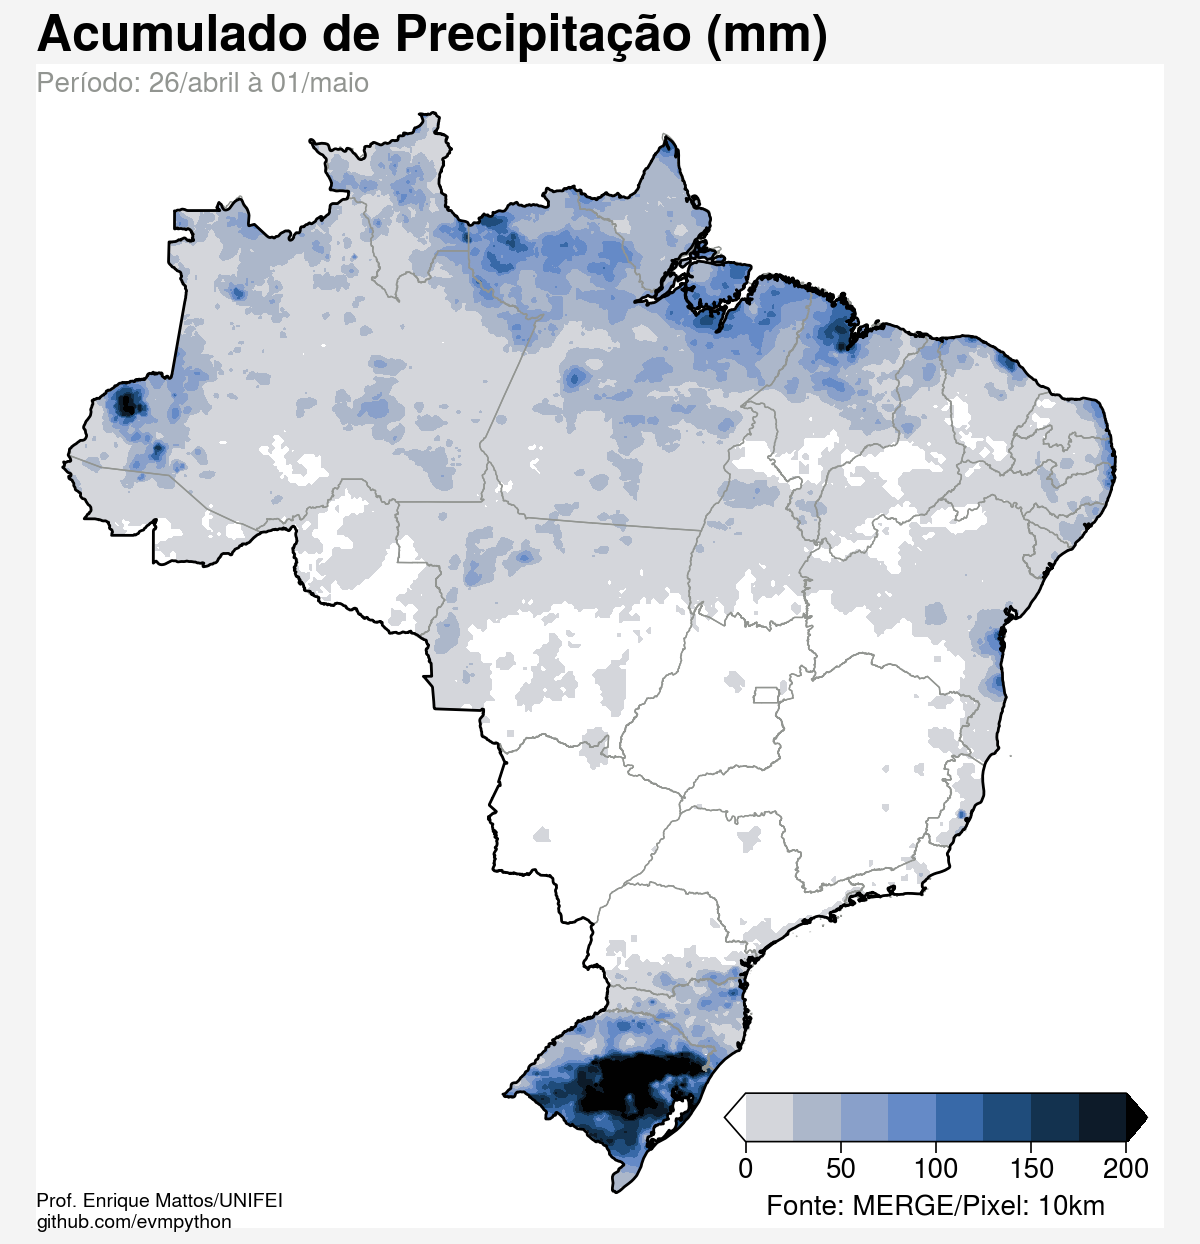

In [20]:
%%time
#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False)

# mapa
map1 = ax.contourf(chuva_merge['lon'],
                   chuva_merge['lat'],
                   chuva_merge['rain'][:,:].salem.roi(shape=shp),
                   cmap='oslo_r',
                   vmin=0, vmax=200,
                   levels=pplt.arange(0, 200, 25),
                   extend='both',
                   colorbar='best',
                   colorbar_kw={'label': 'Fonte: MERGE/Pixel: 10km',
                                'length': 18,
                                'frameon': False,
                                'ticklabelsize': 10,
                                'labelsize': 10,
                                'width': 2,
                                'ticks': 50})

# título da figura
ax.format(title=f'Acumulado de Precipitação (mm)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black')

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'Período: 26/abril à 01/maio', color='grey', fontsize=10)

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax)

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax)

# informação na figura
ax.annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

# salva figura
fig.save(f'precipitacao_merge_{anoi}{mesi}{diai}_{anof}{mesf}{diaf}.jpg', dpi=300)